# Tutorial: Predicting Lid-driven cavity problem parameters with POD-RBF

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial14/tutorial.ipynb)

In this tutorial we will show how to use the **PINA** library to predict the distributions of velocity and pressure the Lid-driven Cavity problem, a benchmark in Computational Fluid Dynamics. The problem consists of a square cavity with a lid on top moving with tangential velocity (by convention to the right), with the addition of no-slip conditions on the walls of the cavity and null static pressure on the lower left angle. 

Our goal is to predict the distributions of velocity and pressure of the fluid inside the cavity as the Reynolds number of the inlet fluid varies. To do so we're using a Reduced Order Model (ROM) based on Proper Orthogonal Decomposition (POD). The parametric solution manifold is approximated here with Radial Basis Function (RBF) Interpolation, a common mesh-free interpolation method that doesn't require trainers or solvers as the found radial basis functions are used to interpolate new points.

Let's start with the necessary imports. We're particularly interested in the `PODBlock` and `RBFBlock` classes which will allow us to define the POD-RBF model.

In [1]:
## routine needed to run the notebook on Google Colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  !pip install "pina-mathlab"

%matplotlib inline

import matplotlib.pyplot as plt
import torch
import pina
import warnings

from pina.model.layers import PODBlock, RBFBlock
from pina import LabelTensor

warnings.filterwarnings('ignore')

/home/matte_b/PINA/pina/model/layers/__init__.py: DeprecationWarning: 'pina.model.layers' is deprecated and will be removed in future versions. Please use 'pina.model.block' instead.


In this tutorial we're gonna use the `LidCavity` class from the [Smithers](https://github.com/mathLab/Smithers) library, which contains a set of parametric solutions of the Lid-driven cavity problem in a square domain. The dataset consists of 300 snapshots of the parameter fields, which in this case are the magnitude of velocity and the pressure, and the corresponding parameter values $u$ and $p$. Each snapshot corresponds to a different value of the tangential velocity $\mu$ of the lid, which has been sampled uniformly between 0.01 m/s and 1 m/s.

Let's start by importing the dataset:

In [2]:
import smithers
from smithers.dataset import LidCavity
dataset = LidCavity()

Let's plot two the data points and the corresponding solution for both parameters at different snapshots, in order to better visualise the data we're using:

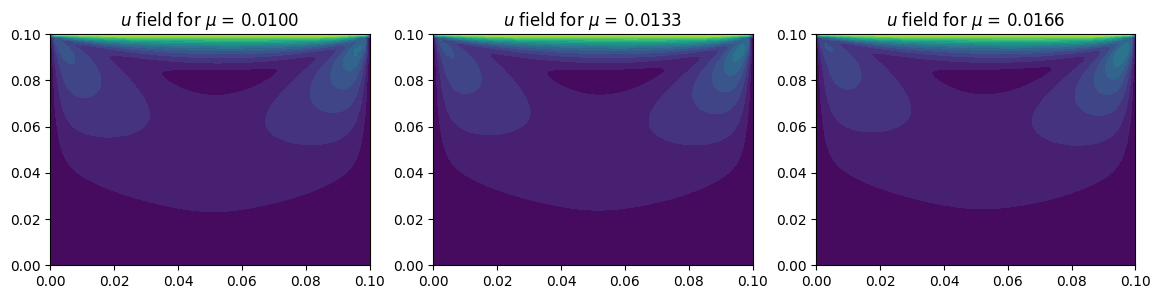

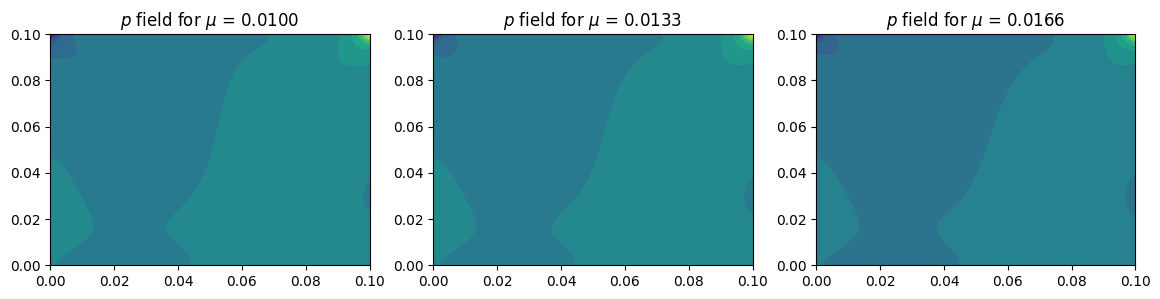

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))
for ax, par, u in zip(axs, dataset.params[:3], dataset.snapshots['mag(v)'][:3]):
    ax.tricontourf(dataset.triang, u, levels=16)
    ax.set_title(f'$u$ field for $\mu$ = {par[0]:.4f}')
fig, axs = plt.subplots(1, 3, figsize=(14, 3))
for ax, par, u in zip(axs, dataset.params[:3], dataset.snapshots['p'][:3]):
    ax.tricontourf(dataset.triang, u, levels=16)
    ax.set_title(f'$p$ field for $\mu$ = {par[0]:.4f}')

To train the model we only need the snapshots for the two parameters. In order to be able to work with the snapshots in **PINA** we first need to assure they're in a compatible format, hence why we start by casting them into `LabelTensor` objects:

In [4]:
'''velocity magnitude data, 5041 for each snapshot'''
u=torch.tensor(dataset.snapshots['mag(v)']).float() 
u = LabelTensor(u, labels=[f's{i}' for i in range(u.shape[1])])
'''pressure data, 5041 for each snapshot'''
p=torch.tensor(dataset.snapshots['p']).float()
p = LabelTensor(p, labels=[f's{i}' for i in range(p.shape[1])])
'''mu corresponding to each snapshot'''
mu=torch.tensor(dataset.params).float()
mu = LabelTensor(mu, labels=['mu'])


The goal of our training is to be able to predict the solution for new test parameters. The first thing we need to do is validate the accuracy of the model, and in order to do so we split the 300 snapshots in training and testing dataset. In the example we set the training `ratio` to 0.9, which means that 90% of the total snapshots is used for training and the remaining 10% for testing.

In [5]:
'''number of snapshots'''
n = u.shape[0]
'''training over total snapshots ratio and number of training snapshots'''
ratio = 0.9 
n_train = int(n*ratio)
'''split u and p data'''
u_train, u_test = u[:n_train], u[n_train:] #for mag(v)
p_train, p_test = p[:n_train], p[n_train:] #for p
'''split snapshots'''
mu_train, mu_test = mu[:n_train], mu[n_train:]

We now proceed by defining the model we intend to use. We inherit from the `torch.nn.Module` class, but in addition we require a `pod_rank` for the POD part and a function `rbf_kernel` in order to perform the RBF part:

In [6]:
class PODRBF(torch.nn.Module):
    """
    Proper orthogonal decomposition with Radial Basis Function interpolation model.
    """
    def __init__(self, pod_rank, rbf_kernel):
        
        super().__init__()
        self.pod = PODBlock(pod_rank)
        self.rbf = RBFBlock(kernel=rbf_kernel)

We complete our model by adding two crucial methods. The first is `forward`, and it expands the input POD coefficients. After being expanded the POD layer needs to be fit, hence why we add a `fit` method that gives us the POD basis (current **PINA** default is by performing truncated Singular Value Decomposition). The same method then uses the basis to fit the RBF interpolation. Overall, the completed class looks like this:

In [7]:
class PODRBF(torch.nn.Module):
    """
    Proper orthogonal decomposition with Radial Basis Function interpolation model.
    """
    def __init__(self, pod_rank, rbf_kernel):
        
        super().__init__()
        self.pod = PODBlock(pod_rank)
        self.rbf = RBFBlock(kernel=rbf_kernel)

    def forward(self, x):
        """
        Defines the computation performed at every call.
        :param x: The tensor to apply the forward pass.
        :type x: torch.Tensor
        :return: the output computed by the model.
        :rtype: torch.Tensor
        """
        coefficients = self.rbf(x)
        return self.pod.expand(coefficients)
    def fit(self, p, x):
        """
        Call the :meth:`pina.model.layers.PODBlock.fit` method of the
        :attr:`pina.model.layers.PODBlock` attribute to perform the POD,
        and the :meth:`pina.model.layers.RBFBlock.fit` method of the
        :attr:`pina.model.layers.RBFBlock` attribute to fit the interpolation.
        """
        self.pod.fit(x)
        self.rbf.fit(p, self.pod.reduce(x))
    

Now that we've built our class, we can fit the model and ask it to predict the parameters for the remaining snapshots. We remember that we don't need to train the model, as it doesn't involve any learnable parameter. The only things we have to set are the rank of the decomposition and the radial basis function (here we use thin plate). Here we focus on predicting the magnitude of velocity:

In [8]:
'''create the model'''
pod_rbfu = PODRBF(pod_rank=20, rbf_kernel='thin_plate_spline')

'''fit the model to velocity training data'''
pod_rbfu.fit(mu_train, u_train)

'''predict the parameter using the fitted model'''
u_train_rbf = pod_rbfu(mu_train)
u_test_rbf = pod_rbfu(mu_test)


Finally we can calculate the relative error for our model:

In [9]:
relative_u_error_train = torch.norm(u_train_rbf - u_train)/torch.norm(u_train)
relative_u_error_test = torch.norm(u_test_rbf - u_test)/torch.norm(u_test)

print('Error summary for POD-RBF model:')
print(f'  Train: {relative_u_error_train.item():e}')
print(f'  Test:  {relative_u_error_test.item():e}')

Error summary for POD-RBF model:
  Train: 8.186904e-03
  Test:  5.140561e-02


The results are promising! Now let's visualise them, comparing four random predicted snapshots to the true ones:

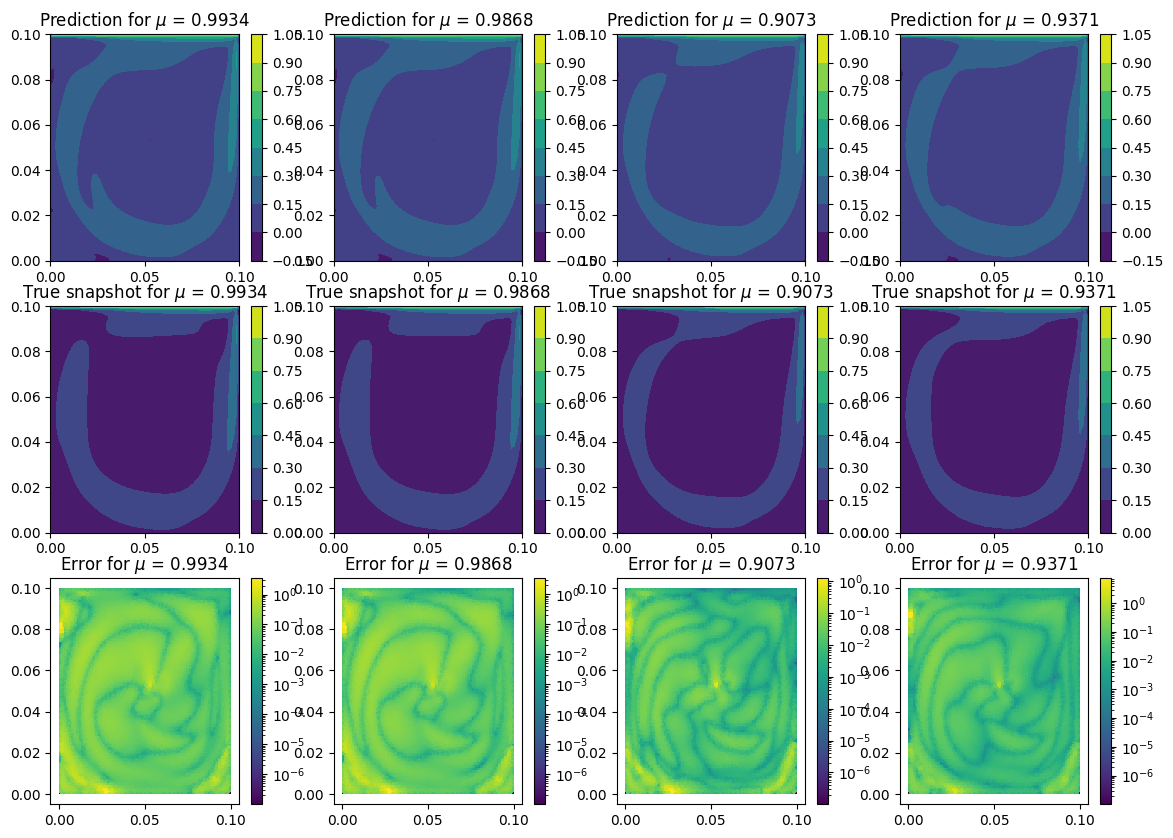

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

idx = torch.randint(0, len(u_test), (4,))
u_idx_rbf = pod_rbfu(mu_test[idx])
fig, axs = plt.subplots(3, 4, figsize=(14, 10))

relative_u_error_rbf = np.abs(u_test[idx] - u_idx_rbf.detach())
relative_u_error_rbf = np.where(u_test[idx] < 1e-7, 1e-7, relative_u_error_rbf/u_test[idx])
                        
for i, (idx_, rbf_, rbf_err_) in enumerate(
    zip(idx, u_idx_rbf, relative_u_error_rbf)):
    axs[0, i].set_title('Prediction for ' f'$\mu$ = {mu_test[idx_].item():.4f}')
    axs[1, i].set_title('True snapshot for ' f'$\mu$ = {mu_test[idx_].item():.4f}')
    axs[2, i].set_title('Error for ' f'$\mu$ = {mu_test[idx_].item():.4f}')

    cm = axs[0, i].tricontourf(dataset.triang, rbf_.detach()) # POD-RBF prediction
    plt.colorbar(cm, ax=axs[0, i])
    
    cm = axs[1, i].tricontourf(dataset.triang, u_test[idx_].flatten()) # Truth
    plt.colorbar(cm, ax=axs[1, i])

    cm = axs[2, i].tripcolor(dataset.triang, rbf_err_, norm=matplotlib.colors.LogNorm()) # Error for POD-RBF
    plt.colorbar(cm, ax=axs[2, i])
    
plt.show()

Overall we have reached a good level of approximation while avoiding time-consuming training procedures. Let's try doing the same to predict the pressure snapshots:

In [11]:
'''create the model'''
pod_rbfp = PODRBF(pod_rank=20, rbf_kernel='thin_plate_spline')

'''fit the model to pressure training data'''
pod_rbfp.fit(mu_train, p_train)

'''predict the parameter using the fitted model'''
p_train_rbf = pod_rbfp(mu_train)
p_test_rbf = pod_rbfp(mu_test)

relative_p_error_train = torch.norm(p_train_rbf - p_train)/torch.norm(p_train)
relative_p_error_test = torch.norm(p_test_rbf - p_test)/torch.norm(p_test)

print('Error summary for POD-RBF model:')
print(f'  Train: {relative_p_error_train.item():e}')
print(f'  Test:  {relative_p_error_test.item():e}')

Error summary for POD-RBF model:
  Train: 5.242423e-02
  Test:  2.334622e+06


Unfortunately here we obtain a very high relative test error, although this is likely due to the nature of the available data. Looking at the plots we can see that the pressure field is subject to high variations between subsequent snapshots, especially here: 

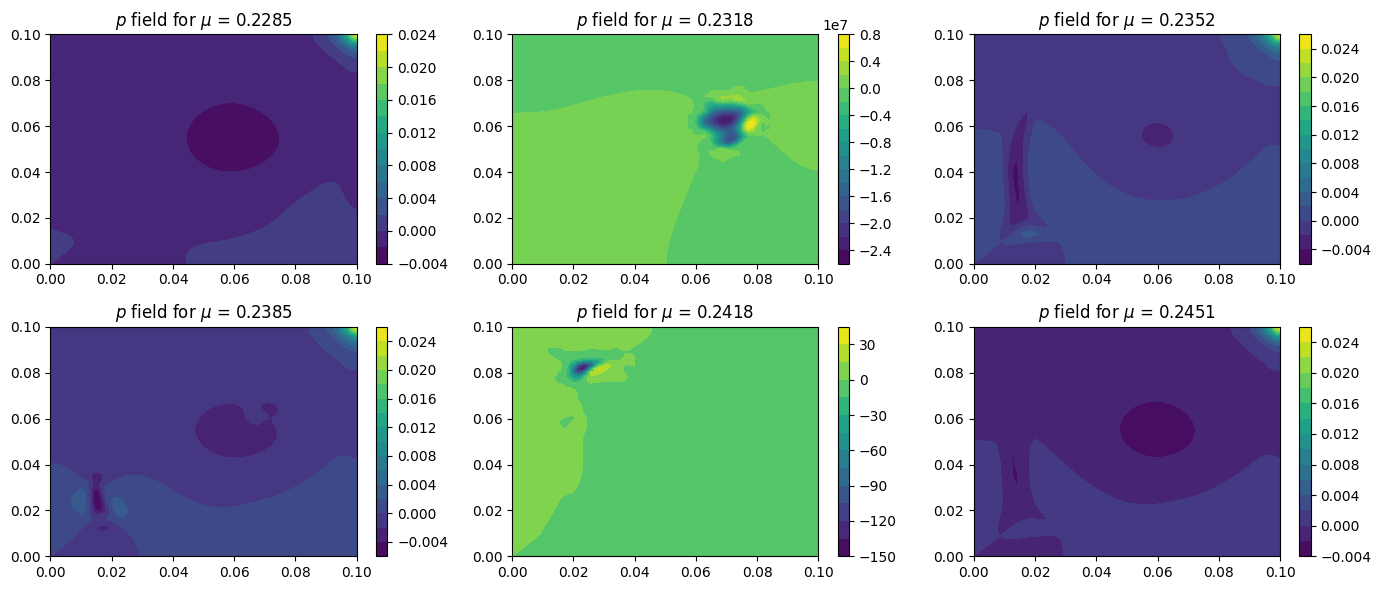

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(14, 6))
for ax, par, u in zip(axs.ravel(), dataset.params[66:72], dataset.snapshots['p'][66:72]):
    cm = ax.tricontourf(dataset.triang, u, levels=16)
    plt.colorbar(cm, ax=ax)
    ax.set_title(f'$p$ field for $\mu$ = {par[0]:.4f}')
plt.tight_layout()
plt.show()



Or here:

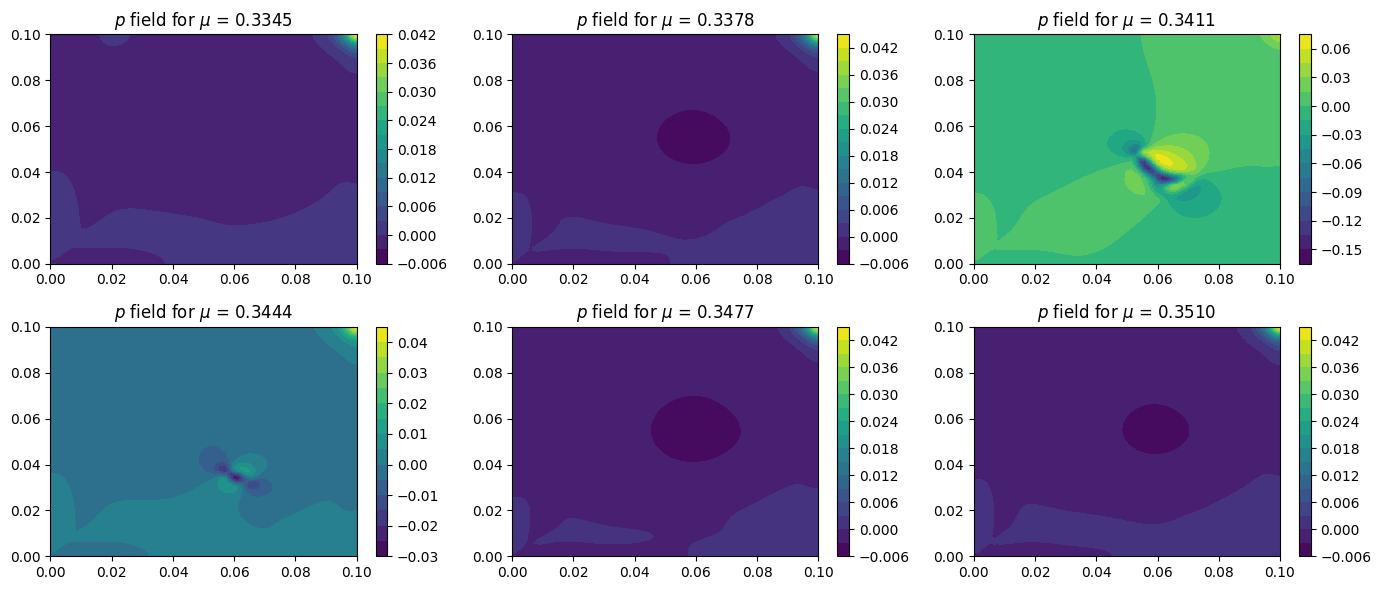

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(14, 6))
for ax, par, u in zip(axs.ravel(), dataset.params[98:104], dataset.snapshots['p'][98:104]):
    cm = ax.tricontourf(dataset.triang, u, levels=16)
    plt.colorbar(cm, ax=ax)
    ax.set_title(f'$p$ field for $\mu$ = {par[0]:.4f}')
plt.tight_layout()  
plt.show()

Scrolling through the velocity snapshots we can observe a more regular behaviour, with no such variations in subsequent snapshots. Moreover, if we decide not to consider the abovementioned "problematic" snapshots, we can already observe a huge improvement:

In [14]:
'''excluding problematic snapshots'''
data = list(range(300))
data_to_consider = data[:67] + data[71:100] + data[102:]
'''proceed as before'''
newp=torch.tensor(dataset.snapshots['p'][data_to_consider]).float()
newp = LabelTensor(newp, labels=[f's{i}' for i in range(newp.shape[1])])

newmu=torch.tensor(dataset.params[data_to_consider]).float()
newmu = LabelTensor(newmu, labels=['mu'])

newn = newp.shape[0]
ratio = 0.9 
new_train = int(newn*ratio)

new_p_train, new_p_test = newp[:new_train], newp[new_train:] 

new_mu_train, new_mu_test = newmu[:new_train], newmu[new_train:]

new_pod_rbfp = PODRBF(pod_rank=20, rbf_kernel='thin_plate_spline')

new_pod_rbfp.fit(new_mu_train, new_p_train)

new_p_train_rbf = new_pod_rbfp(new_mu_train)
new_p_test_rbf = new_pod_rbfp(new_mu_test)

new_relative_p_error_train = torch.norm(new_p_train_rbf - new_p_train)/torch.norm(new_p_train)
new_relative_p_error_test = torch.norm(new_p_test_rbf - new_p_test)/torch.norm(new_p_test)

print('Error summary for POD-RBF model:')
print(f'  Train: {new_relative_p_error_train.item():e}')
print(f'  Test:  {new_relative_p_error_test.item():e}')

Error summary for POD-RBF model:
  Train: 3.663579e-02
  Test:  1.704214e-01


## What's next?

Congratulations on completing the **PINA** tutorial on building and using a custom POD class! Now you can try:

1. Varying the inputs of the model (for a list of the supported RB functions look at the `rbf_layer.py` file in `pina.layers`)

2. Changing the POD model, for example using Artificial Neural Networks. For a more in depth overview of POD-NN and a comparison with the POD-RBF model already shown, look at [Tutorial: Reduced order model (POD-RBF or POD-NN) for parametric problems](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial9/tutorial.ipynb)

3. Building your own classes or adapt the one shown to other datasets/problems